In [67]:
import matplotlib.pyplot as plt
import numpy as np
import random

### Load data

In [70]:
labels = np.load('../data/ydata_7class.npy')
shapes = np.load('../data/xdata_7class.npy')

### Apply damage

In [73]:
def apply_damage(live_mask, radius=2, damage_type='sphere', random_proportion=None, damage_center=None):
    """
    Apply damage to a 3D shape based on various damage modes.
    
    Args:
        live_mask: 3D numpy array where 1 represents live cells and 0 represents dead cells
        radius: Radius of the damage area (for sphere/cube mode)
        damage_type: 'sphere', 'cube', or 'random'
        random_proportion: If damage_type is 'random', proportion of live cells to damage (0.0-1.0)
        damage_center: Optional specific coordinate to use as damage center (x,y,z)
        
    Returns:
        new_live_mask: Updated live mask after damage
        damage_direction: 3D array indicating direction of nearby damage (0-6)
    """
    # Create copies to avoid modifying the original
    new_live_mask = np.copy(live_mask)
    shape = new_live_mask.shape
    
    # Find all live cells
    live_indices = np.argwhere(live_mask == 1)
    
    if len(live_indices) == 0:
        print("No live cells to damage!")
        return new_live_mask, np.zeros_like(new_live_mask)
    
    # Random proportion damage mode
    if damage_type == 'random' and random_proportion is not None:
        if random_proportion <= 0 or random_proportion > 1:
            raise ValueError("Random proportion must be between 0 and 1")
        
        # Determine how many cells to damage
        num_live_cells = len(live_indices)
        num_cells_to_damage = int(num_live_cells * random_proportion)
        
        # Randomly select cells to damage
        cells_to_damage = random.sample(range(num_live_cells), num_cells_to_damage)
        
        # Apply damage to selected cells
        for idx in cells_to_damage:
            x, y, z = live_indices[idx]
            new_live_mask[x, y, z] = 0
    
    # Sphere or Cube damage mode
    else:
        # Pick a random live cell as the damage center if not provided
        if damage_center is None:
            damage_center = random.choice(live_indices)
        
        x0, y0, z0 = damage_center
        
        # Apply damage based on type
        for x in range(max(0, x0-radius), min(shape[0], x0+radius+1)):
            for y in range(max(0, y0-radius), min(shape[1], y0+radius+1)):
                for z in range(max(0, z0-radius), min(shape[2], z0+radius+1)):
                    if damage_type == 'sphere':
                        # Calculate Euclidean distance for spherical damage
                        distance = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
                        if distance <= radius:
                            new_live_mask[x, y, z] = 0
                    elif damage_type == 'cube':
                        new_live_mask[x, y, z] = 0
    
    # Create damage direction array
    damage_direction = np.zeros_like(new_live_mask)
    
    # Check each live cell to see if it's adjacent to damaged cells
    for x in range(shape[0]):
        for y in range(shape[1]):
            for z in range(shape[2]):
                if new_live_mask[x, y, z] == 1:  # Only check live cells
                    # Check the 6 adjacent directions
                    if x > 0 and live_mask[x-1, y, z] == 1 and new_live_mask[x-1, y, z] == 0:
                        damage_direction[x, y, z] = 1  # Damage in -x direction
                    elif x < shape[0]-1 and live_mask[x+1, y, z] == 1 and new_live_mask[x+1, y, z] == 0:
                        damage_direction[x, y, z] = 2  # Damage in +x direction
                    elif y > 0 and live_mask[x, y-1, z] == 1 and new_live_mask[x, y-1, z] == 0:
                        damage_direction[x, y, z] = 3  # Damage in -y direction
                    elif y < shape[1]-1 and live_mask[x, y+1, z] == 1 and new_live_mask[x, y+1, z] == 0:
                        damage_direction[x, y, z] = 4  # Damage in +y direction
                    elif z > 0 and live_mask[x, y, z-1] == 1 and new_live_mask[x, y, z-1] == 0:
                        damage_direction[x, y, z] = 5  # Damage in -z direction
                    elif z < shape[2]-1 and live_mask[x, y, z+1] == 1 and new_live_mask[x, y, z+1] == 0:
                        damage_direction[x, y, z] = 6  # Damage in +z direction
    
    return new_live_mask, damage_direction

In [74]:
table = shapes[np.where(labels == 3)[0][0]]

In [83]:
sphere_damage_mask, sphere_damage_direction = apply_damage(table, radius=2, damage_type='sphere')
random_damage_mask, random_damage_direction = apply_damage(table, damage_type='random', random_proportion=0.1)

### Visualize

In [84]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import random

def plot_damage_voxels(live_mask, damage_direction):
    """
    Plot a 3D visualization of the live mask with damage directions.
    
    Args:
        live_mask: 3D numpy array where 1 represents live cells and 0 represents dead cells
        damage_direction: 3D array indicating direction of nearby damage (0-6)
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Define color map for damage directions
    color_map = {
        0: "blue",     # No damage direction
        1: "gray",     # Damage in -x direction
        2: "orange",   # Damage in +x direction
        3: "purple",   # Damage in -y direction
        4: "pink",     # Damage in +y direction
        5: "yellow",   # Damage in -z direction
        6: "black"     # Damage in +z direction
    }
    
    # Create a 3D array of colors
    colors_array = np.empty(live_mask.shape, dtype=object)
    
    # Fill the colors array based on live cells and damage direction
    for x in range(live_mask.shape[0]):
        for y in range(live_mask.shape[1]):
            for z in range(live_mask.shape[2]):
                if live_mask[x, y, z] == 1:  # Cell is alive
                    direction = int(damage_direction[x, y, z])
                    colors_array[x, y, z] = color_map[direction]
                else:
                    colors_array[x, y, z] = None  # Dead or damaged cells are transparent
    
    # Plot the voxels
    ax.voxels(live_mask, facecolors=colors_array, edgecolor='k', alpha=0.7)
    
    # Add a legend for color meanings
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, color="blue", label="No Damage Direction"),
        plt.Rectangle((0, 0), 1, 1, color="gray", label="Damage in -X Direction"),
        plt.Rectangle((0, 0), 1, 1, color="orange", label="Damage in +X Direction"),
        plt.Rectangle((0, 0), 1, 1, color="purple", label="Damage in -Y Direction"),
        plt.Rectangle((0, 0), 1, 1, color="pink", label="Damage in +Y Direction"),
        plt.Rectangle((0, 0), 1, 1, color="yellow", label="Damage in -Z Direction"),
        plt.Rectangle((0, 0), 1, 1, color="black", label="Damage in +Z Direction")
    ]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.3, 1))
    
    # Set plot title and labels
    ax.set_title('3D Voxels with Damage Visualization')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    
    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])
    
    plt.tight_layout()
    # Instead of saving the figure, directly convert it to a PIL image
    from io import BytesIO
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close(fig)
    buf.seek(0)
    pil_image = Image.open(buf)
    # pil_image.save(name)
    return pil_image


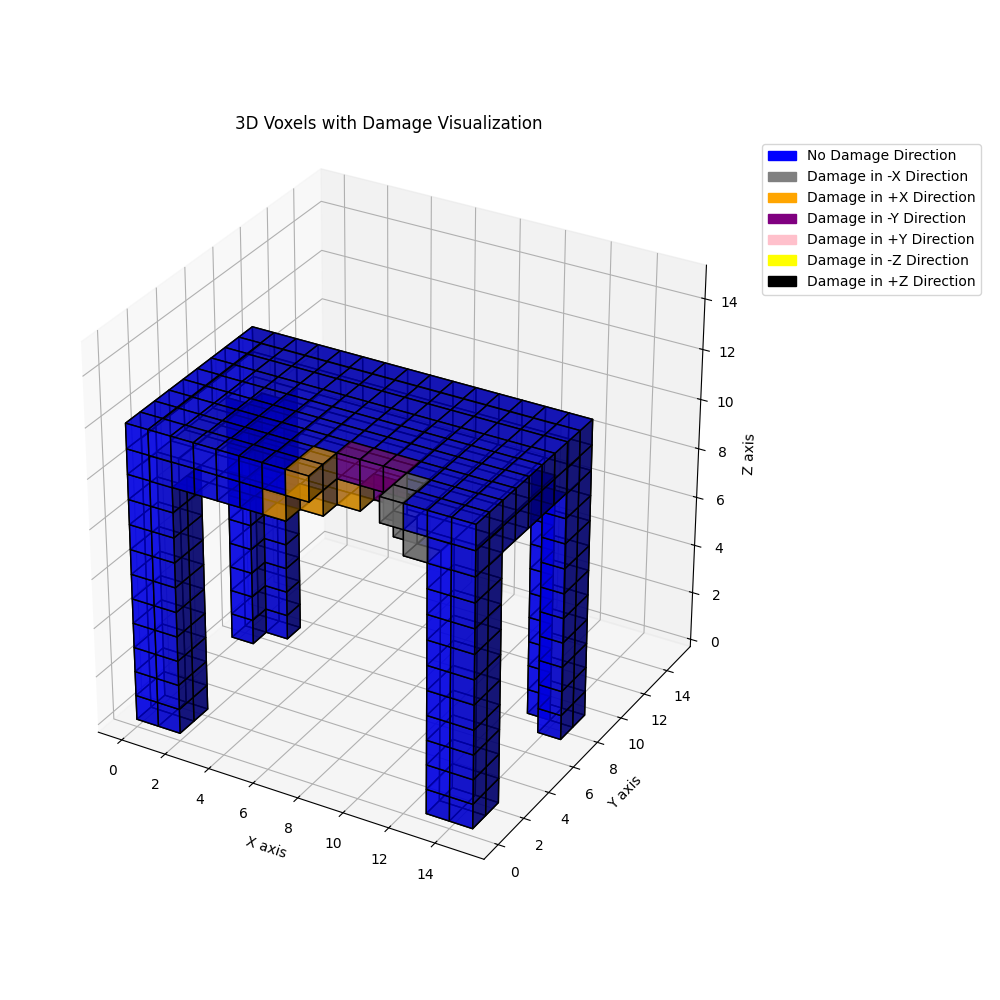

In [85]:
plot_damage_voxels(live_mask=sphere_damage_mask, damage_direction=sphere_damage_direction)

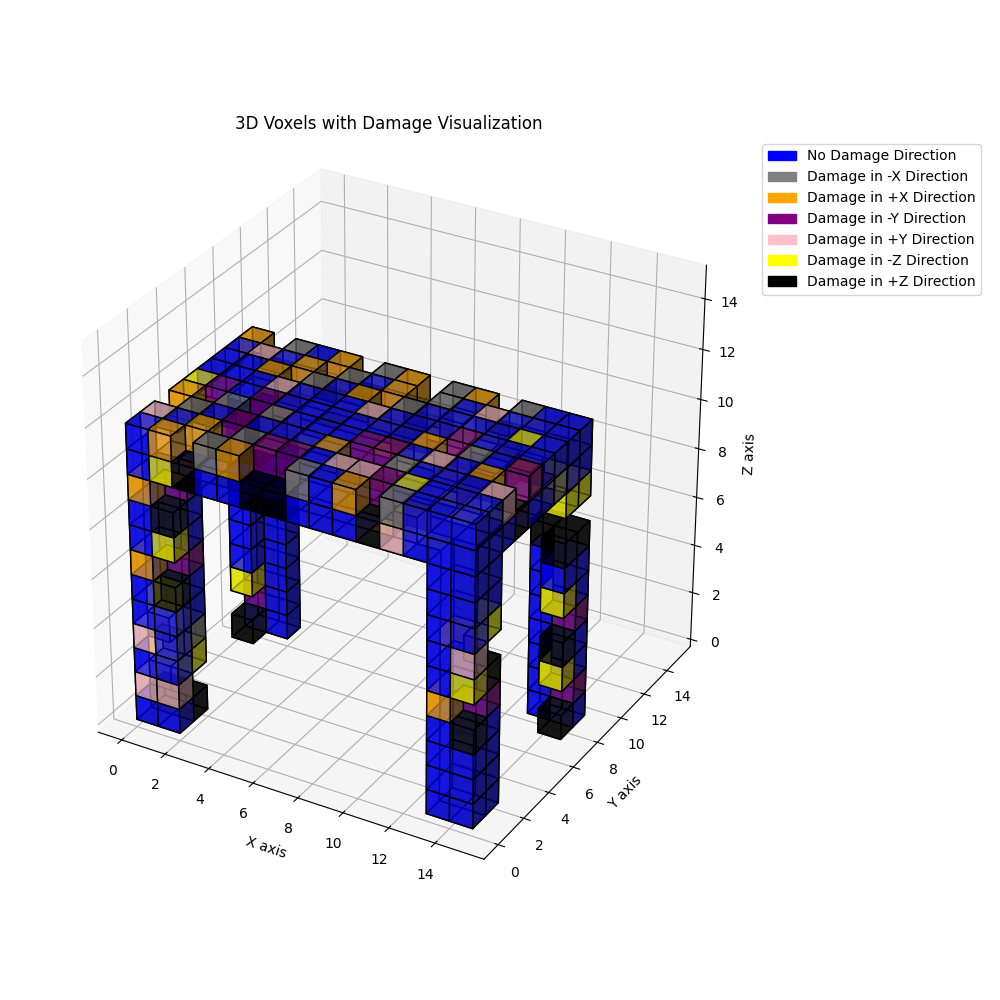

In [86]:
plot_damage_voxels(live_mask=random_damage_mask, damage_direction=random_damage_direction)

In [42]:
table = shapes[np.where(labels == 3)[0][0]]

In [47]:
color_arr = convert_to_color(table, alive_mask)

In [53]:
color_arr

(450,)

{(2, 0, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x135962b90>,
 (2, 0, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125b3aad0>,
 (2, 1, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125b3b610>,
 (2, 1, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125b3bf10>,
 (2, 2, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd4400>,
 (2, 2, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd4790>,
 (2, 3, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd4b20>,
 (2, 3, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd4eb0>,
 (2, 4, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd5240>,
 (2, 4, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd55d0>,
 (2, 5, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd5960>,
 (2, 5, 14): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd5cf0>,
 (2, 6, 0): <mpl_toolkits.mplot3d.art3d.Poly3DCollection at 0x125bd6080>,
 (2, 6, 14): <mpl_toolkits.mplot

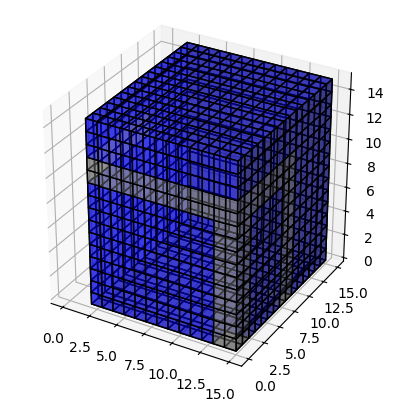

In [54]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.voxels(color_arr, edgecolor="k", facecolors=color_arr, alpha=0.5)


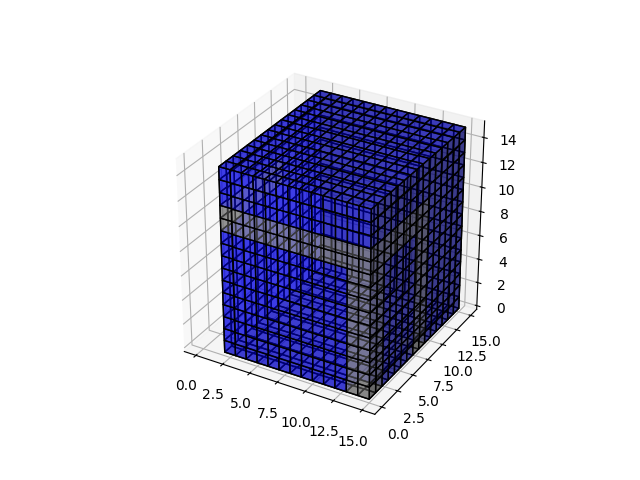

In [48]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_aspect('equal')

ax.voxels(color_arr, edgecolor="k", facecolors=color_arr, alpha=0.5)

# Instead of saving the figure, directly convert it to a PIL image
from io import BytesIO
buf = BytesIO()
plt.savefig(buf, format='png')
plt.close(fig)
buf.seek(0)
pil_image = Image.open(buf)
# pil_image.save(name)
pil_image

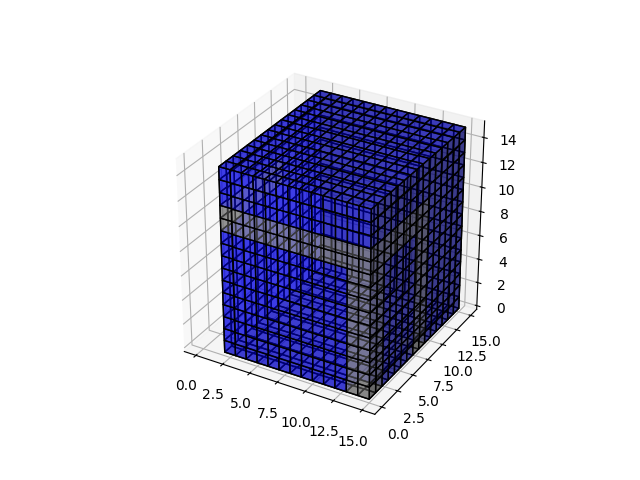

In [44]:
plot_arr(table, alive_mask)